#### Data fields description:

ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

date - date in format dd/mm/yyyy

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

item_name - name of item

shop_name - name of shop

item_category_name - name of item category

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
test = pd.read_csv('../Data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('../Data/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('../Data/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('../Data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('../Data/sales_train.csv',parse_dates=['date'],
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [3]:
display(sales.head())
display(test.head())
display(item_categories.head())
display(items.head())
display(shops.head())

print(sales.dtypes)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


date               object
date_block_num      int32
shop_id             int32
item_id             int32
item_price        float32
item_cnt_day        int32
dtype: object


Join data sets

In [4]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
print(train.shape)
train.head()

(2935849, 10)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [5]:
# Create a column "item_price_sum"
train['item_price_sum'] = train['item_price'] * train['item_cnt_day']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,item_price_sum
0,02.01.2013,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.00
1,03.01.2013,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.00
2,05.01.2013,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.00
3,06.01.2013,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.05
4,15.01.2013,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.00


In [6]:
train.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [7]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_price_sum
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00,1157.73
std,9.42,16.23,6324.30,1729.80,2.62,17.10,5683.60
min,0.00,0.00,0.00,-1.00,-22.00,0.00,-68970.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00,249.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00,449.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00,1078.20
max,33.00,59.00,22169.00,307980.00,2169.00,83.00,1829990.00


Time period of the dataset

In [8]:
print('Min date from train set: %s' % pd.to_datetime(train['date'], format='%d.%m.%Y').min().date())
print('Max date from train set: %s' % pd.to_datetime(train['date'], format='%d.%m.%Y').max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-10-31


I'll only be using only the "shop_id" and "item_id" that appear on the test set.

In [9]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

# Only shops that exist in test set.
train_new = train[train['shop_id'].isin(test_shop_ids)]

# Only items that exist in test set.
train_new = train_new[train_new['item_id'].isin(test_item_ids)]

In [10]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', train_new.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


Only records with "item_price_sum" > 0.

In [11]:
train_new = train_new[train_new['item_price_sum'] > 0]
print('Data set size after cleaning:', train_new.shape[0])

Data set size after cleaning: 1221498


I'm dropping the text features since I won't be doing anything with them.
We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's remove unwanted columns and aggregate the data by month.

In [12]:
# Select only useful features.
train_monthly = train_new[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price','item_price_sum', 'item_cnt_day']]
train_monthly.head()

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_sum,item_cnt_day
0,02.01.2013,0,59,37,22154,999.00,999.00,1
10,03.01.2013,0,25,55,2574,399.00,798.00,2
11,05.01.2013,0,25,55,2574,399.00,399.00,1
12,07.01.2013,0,25,55,2574,399.00,399.00,1
13,08.01.2013,0,25,55,2574,399.00,798.00,2


In [13]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price_sum':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
display(train_monthly.head())
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id',  'item_id', 'sum_item_price_month', 'mean_item_price', 'sum_item_cnt_month', 'mean_item_cnt', 'transactions_month']
display(train_monthly.head())


date_block_num shop_id item_category_id item_id item_price_sum          \
                                                             sum    mean   
0              0       2                2    5572       13910.00 1987.14   
1              0       2                2    5643        2390.00 2390.00   
2              0       2                5    5583        1188.30  594.15   
3              0       2                6    7893        5970.00 1990.00   
4              0       2                6    7894        1490.00 1490.00   

  item_cnt_day             
           sum mean count  
0            9 1.29     7  
1            1 1.00     1  
2            2 1.00     2  
3            3 1.00     3  
4            1 1.00     1

,date_block_num,shop_id,item_category_id,item_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month
0,0,2,2,5572,13910.00,1987.14,9,1.29,7
1,0,2,2,5643,2390.00,2390.00,1,1.00,1
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1


To mimic the real behavior of the data we have to create the missing records from the loaded dataset, so for each month we need to create the missing records for each shop and item, since we don't have data for them I'll replace them with 0.

In [14]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
empty_df.shape

(6734448, 3)

In [15]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)
display(train_monthly.head().T)

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
sum_item_price_month,13910.00,2390.00,1188.30,5970.00,1490.00
mean_item_price,1987.14,2390.00,594.15,1990.00,1490.00
sum_item_cnt_month,9.00,1.00,2.00,3.00,1.00
mean_item_cnt,1.29,1.00,1.00,1.00,1.00
transactions_month,7.00,1.00,2.00,3.00,1.00


In [16]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,3.78,13.21,0.00,0.00,0.00,0.00,83.00
sum_item_price_month,6734448.00,255.69,6074.12,0.00,0.00,0.00,0.00,6264229.93
mean_item_price,6734448.00,93.79,1295.93,0.00,0.00,0.00,0.00,996950.00
sum_item_cnt_month,6734448.00,0.24,3.46,0.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,0.00,0.00,0.00,0.00,1000.00
transactions_month,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00


In [17]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,month
0,0,2,5572,2.00,13910.00,1987.14,9.00,1.29,7.00,2013,0
1,0,2,5643,2.00,2390.00,2390.00,1.00,1.00,1.00,2013,0
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0


# EDA

In [18]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['sum_item_cnt_month'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['sum_item_cnt_month'].sum()

gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['sum_item_cnt_month'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['sum_item_cnt_month'].sum()

gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['sum_item_cnt_month'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['sum_item_cnt_month'].sum()

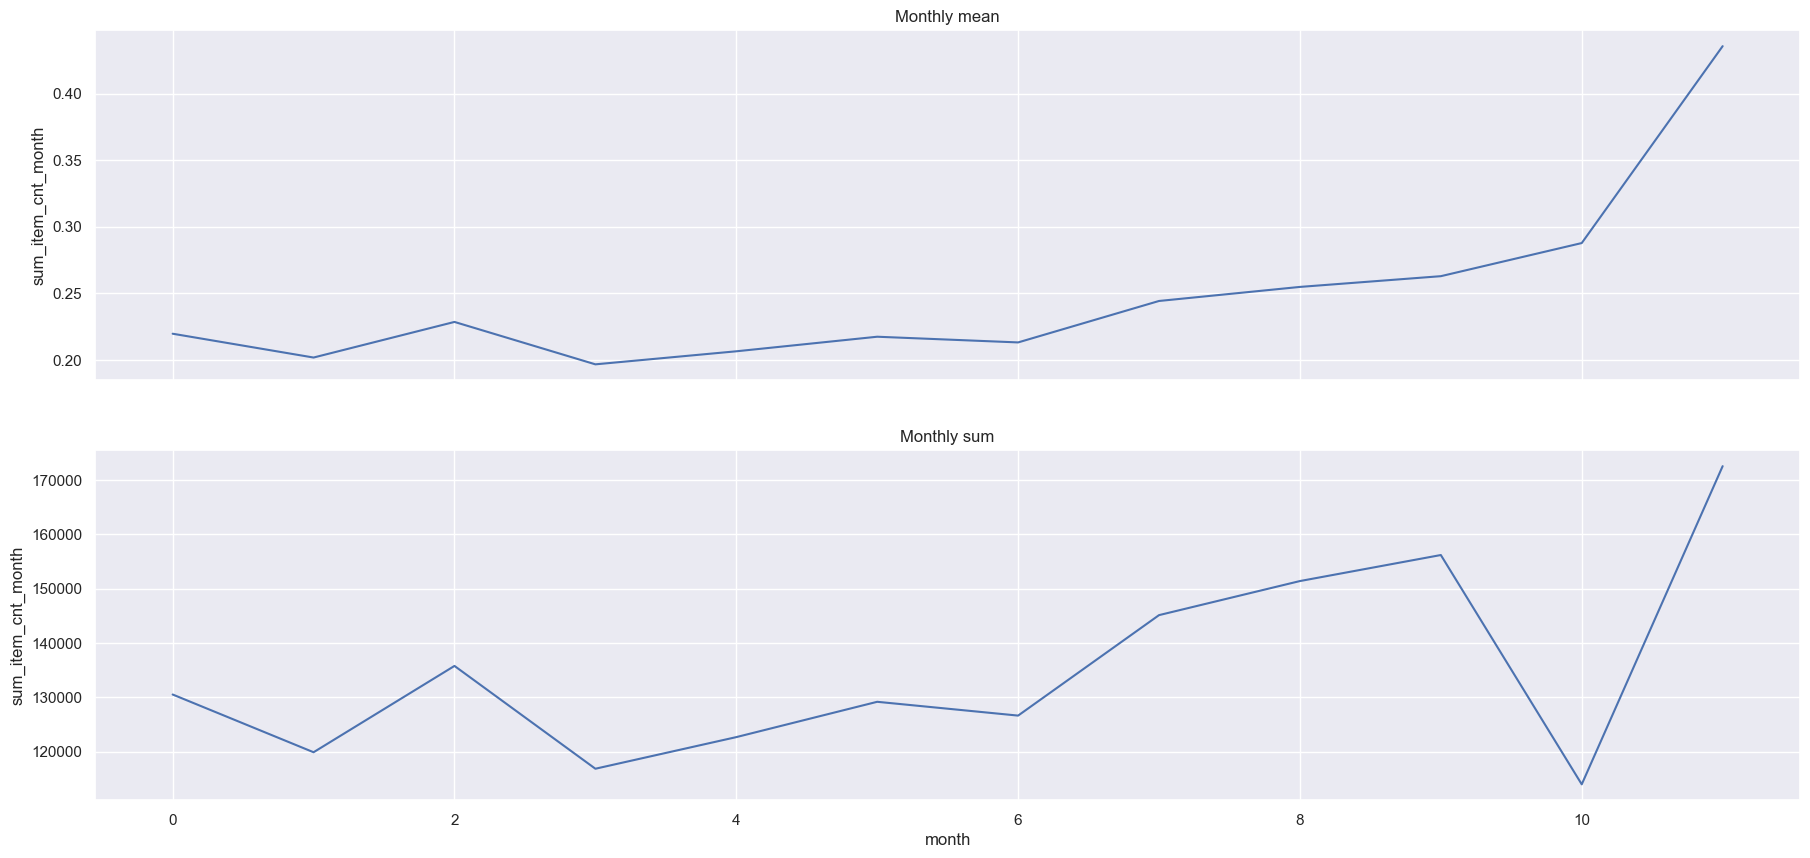

In [19]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="sum_item_cnt_month", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="sum_item_cnt_month", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

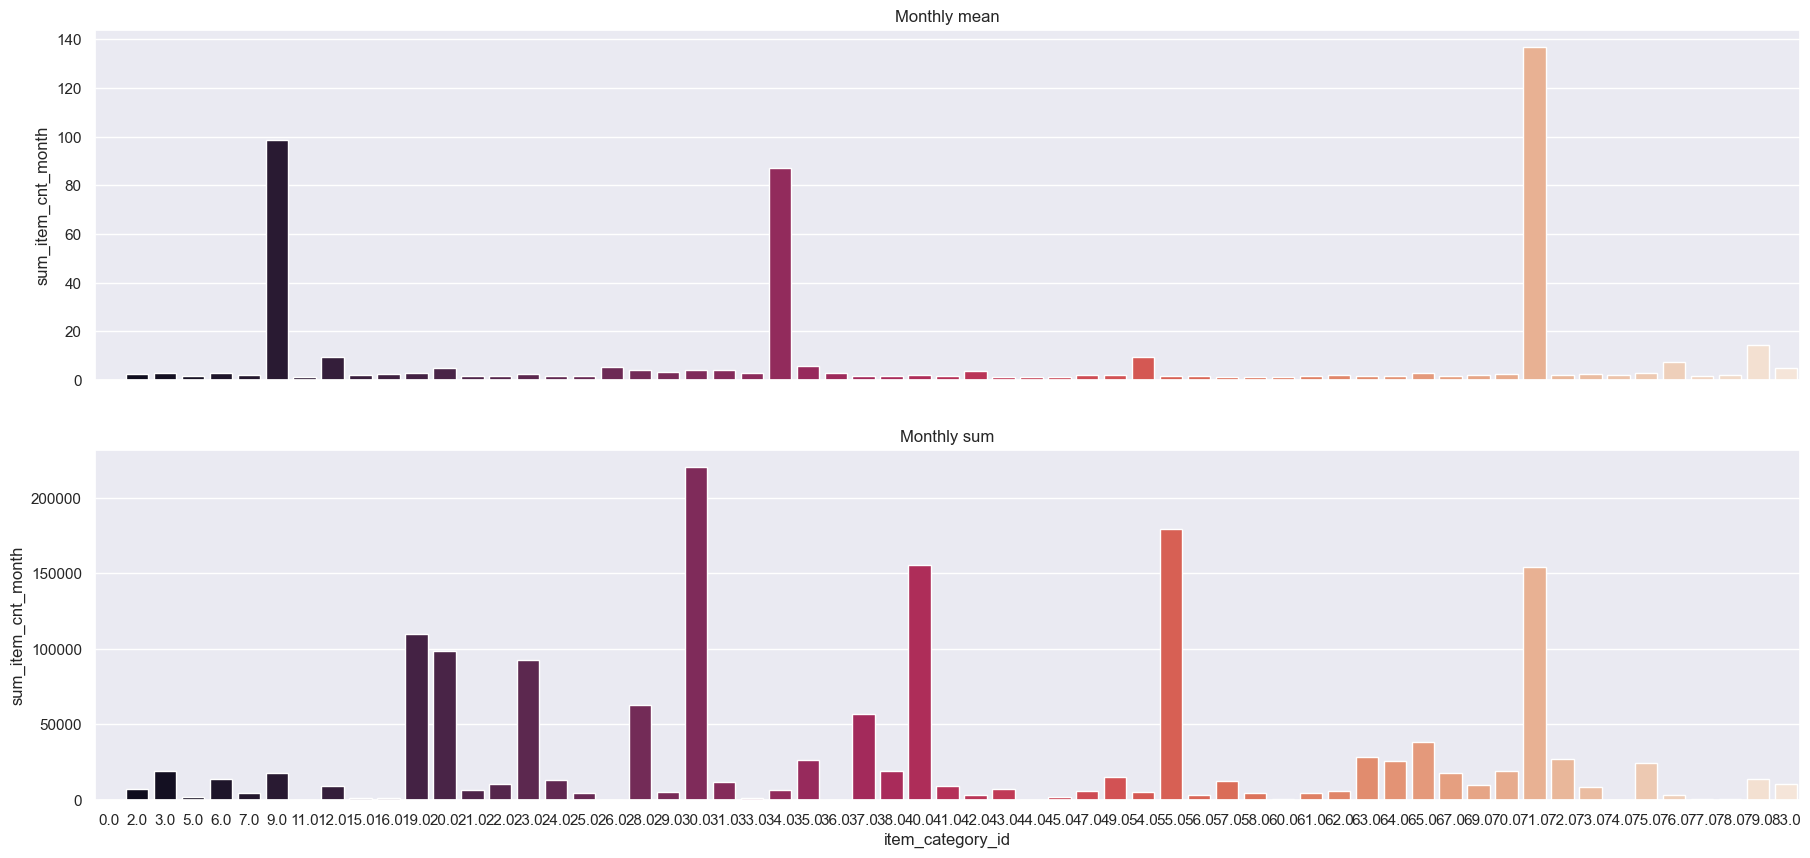

In [20]:
# what categories sell more?
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="sum_item_cnt_month", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="sum_item_cnt_month", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

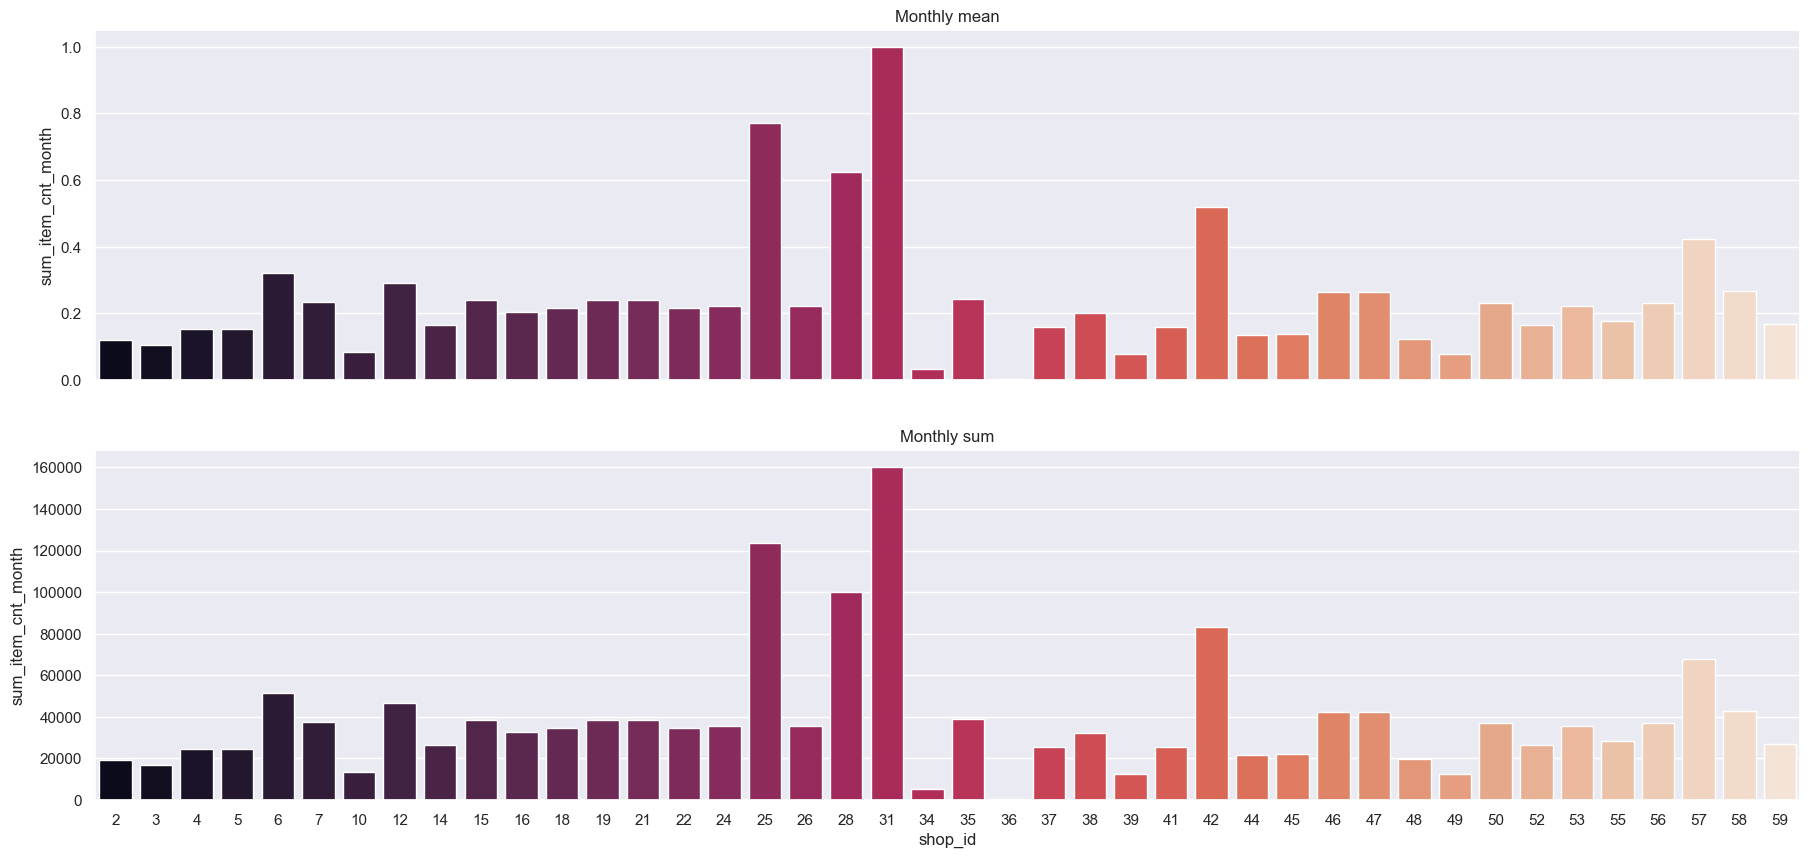

In [21]:
# What shops sell most
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="sum_item_cnt_month", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="sum_item_cnt_month", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In conclusion, as we can see:
1) we have a trending increase of item sales count (mean) towards the ending of the year.
2) Also only few of the categories seems to hold most of the sell count.
3) Most of the shops have a similar sell rate, but 3 of them have a much higher rate, this may be a indicative of the shop size.


### Checking for outliers

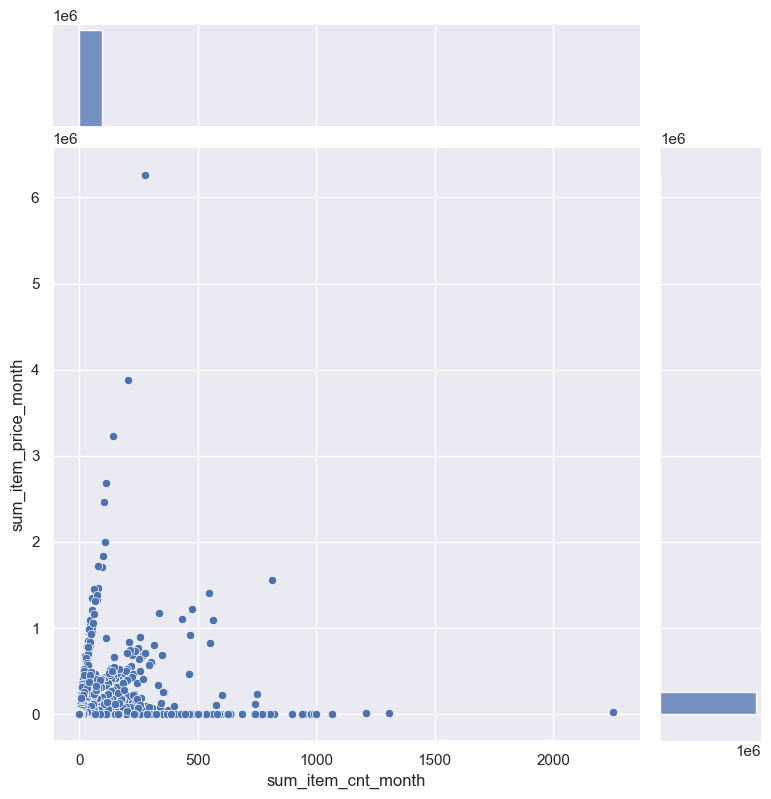

In [22]:
sns.jointplot(x="sum_item_cnt_month", y="sum_item_price_month", data=train_monthly, height=8)
plt.show()

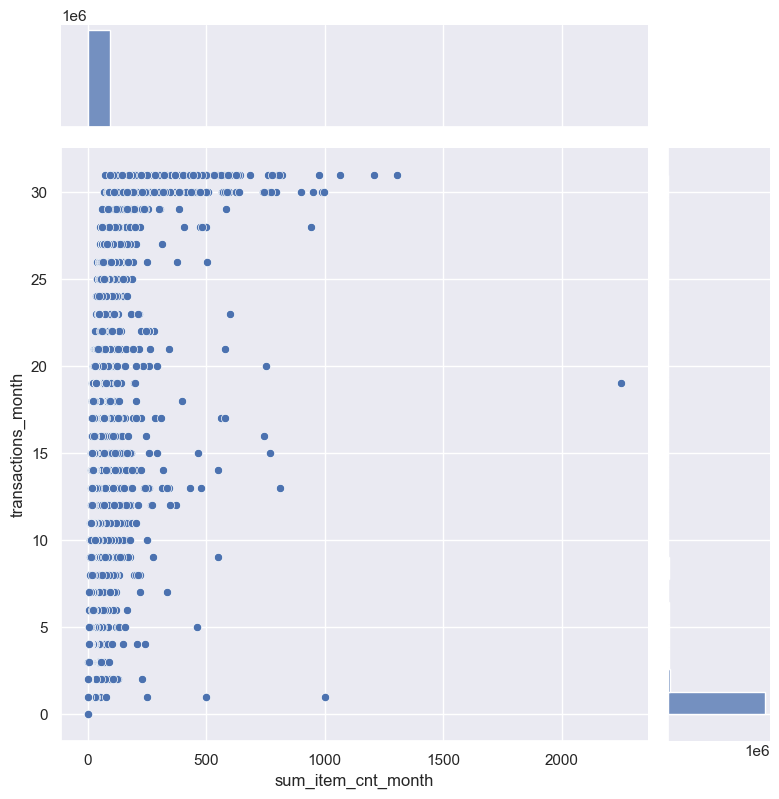

In [23]:
sns.jointplot(x="sum_item_cnt_month", y="transactions_month", data=train_monthly, height=8)
plt.show()

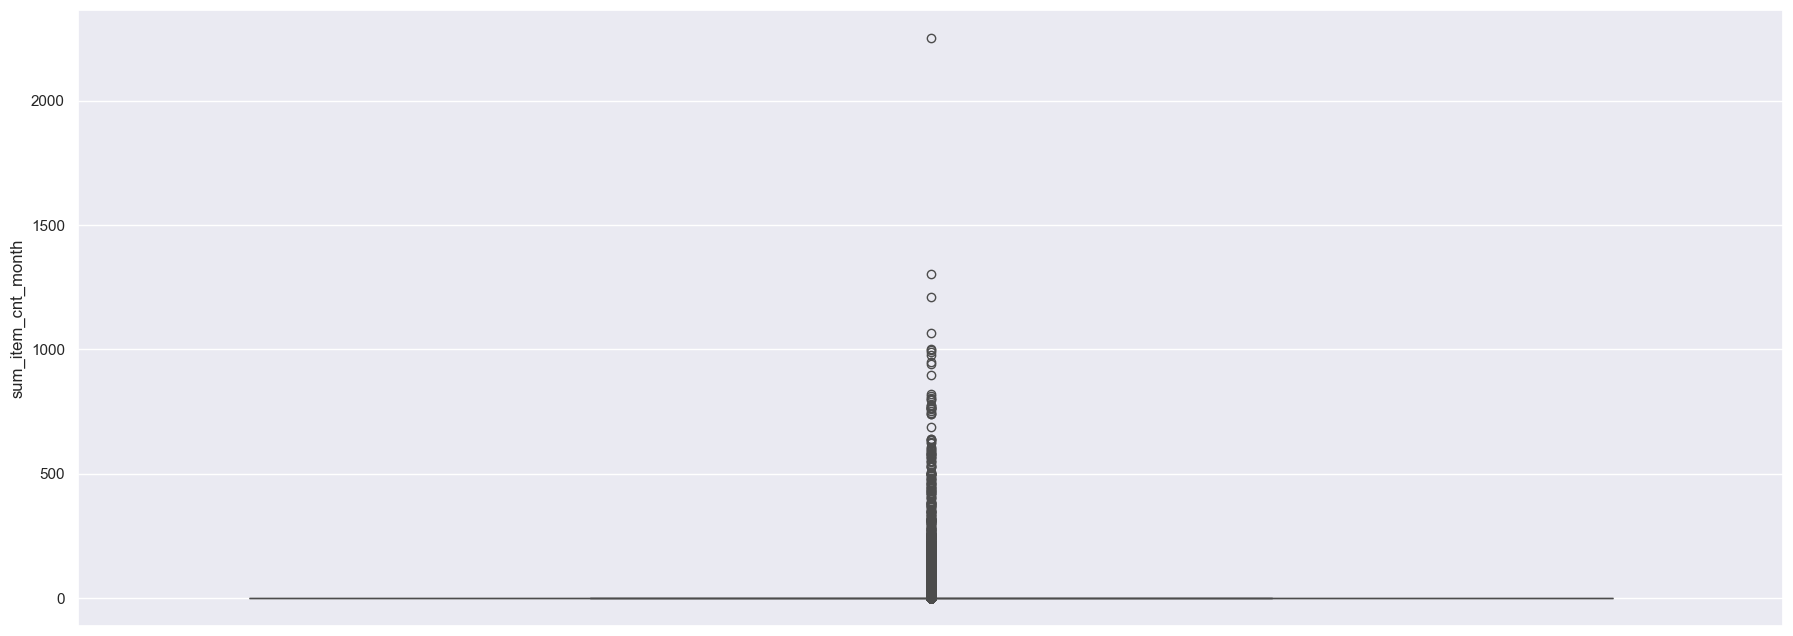

In [24]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['sum_item_cnt_month'])
plt.show()

Removing outliers
I'll treat "item_cnt" > 1500 and < 0, "item_price" > 40,000 as outliers, so I'll remove them.

In [25]:
train_monthly = train_monthly.query('sum_item_cnt_month >= 0 and sum_item_price_month <= 1500 and sum_item_price_month <= 400000')

# Feature engineering

### Creating the label

Our label will be the "item_cnt" of the next month, as we are dealing with a forecast problem.

In [26]:
train_monthly['item_cnt_next_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['sum_item_cnt_month'].shift(-1)
display(train_monthly.head())
train_monthly.shape

,date_block_num,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,month,item_cnt_next_month
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,1.00
7,0,2,1409,19.00,1398.50,1398.50,1.00,1.00,1.00,2013,0,0.00
8,0,2,1467,19.00,899.00,899.00,1.00,1.00,1.00,2013,0,0.00
9,0,2,3076,19.00,1399.00,1399.00,1.00,1.00,1.00,2013,0,1.00


(6552139, 12)

Unitary item prices.

In [27]:
# train_monthly['item_price_unit'] = train_monthly['sum_item_price_month'] // train_monthly['sum_item_cnt_month']
# train_monthly['item_price_unit'].fillna(0, inplace=True)

train_monthly['item_price_unit'] = np.where(train_monthly['sum_item_cnt_month']>0, train_monthly['sum_item_price_month'] // train_monthly['sum_item_cnt_month'], np.nan)
train_monthly['item_price_unit'].fillna(0, inplace=True)
train_monthly.head()
 

,date_block_num,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,month,item_cnt_next_month,item_price_unit
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00,594.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,1.00,1490.00
7,0,2,1409,19.00,1398.50,1398.50,1.00,1.00,1.00,2013,0,0.00,1398.00
8,0,2,1467,19.00,899.00,899.00,1.00,1.00,1.00,2013,0,0.00,899.00
9,0,2,3076,19.00,1399.00,1399.00,1.00,1.00,1.00,2013,0,1.00,1399.00


Group based features.

In [28]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price_unit':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')
display(train_monthly.head())

,date_block_num,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,month,item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00,594.00,0.00,699.00
1,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,1.00,1490.00,0.00,1490.00
2,0,2,1409,19.00,1398.50,1398.50,1.00,1.00,1.00,2013,0,0.00,1398.00,0.00,1399.00
3,0,2,1467,19.00,899.00,899.00,1.00,1.00,1.00,2013,0,0.00,899.00,0.00,1199.00
4,0,2,3076,19.00,1399.00,1399.00,1.00,1.00,1.00,2013,0,1.00,1399.00,0.00,1399.00


How much each item's price changed from its (lowest/highest) historical price.

In [29]:
train_monthly['price_increase'] = train_monthly['item_price_unit'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price_unit']
display(train_monthly.head())

,date_block_num,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,month,item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00,594.00,0.00,699.00,594.00,105.00
1,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,1.00,1490.00,0.00,1490.00,1490.00,0.00
2,0,2,1409,19.00,1398.50,1398.50,1.00,1.00,1.00,2013,0,0.00,1398.00,0.00,1399.00,1398.00,1.00
3,0,2,1467,19.00,899.00,899.00,1.00,1.00,1.00,2013,0,0.00,899.00,0.00,1199.00,899.00,300.00
4,0,2,3076,19.00,1399.00,1399.00,1.00,1.00,1.00,2013,0,1.00,1399.00,0.00,1399.00,1399.00,0.00


Rolling window based features (window = 3 months).

In [30]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = list(train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['sum_item_cnt_month'].apply(function_list[i]))

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)



Lag based features.

In [31]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['sum_item_cnt_month'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,...,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3
0,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,699.00,594.00,105.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,...,1490.00,1490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,2,1409,19.00,1398.50,1398.50,1.00,1.00,1.00,2013,...,1399.00,1398.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0,2,1467,19.00,899.00,899.00,1.00,1.00,1.00,2013,...,1199.00,899.00,300.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0,2,3076,19.00,1399.00,1399.00,1.00,1.00,1.00,2013,...,1399.00,1399.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Item sales count trend.

In [32]:
# train_monthly['item_trend'] = train_monthly['sum_item_cnt_month']

# for lag in lag_list:
#     ft_name = ('item_cnt_shifted%s' % lag)
#     train_monthly['item_trend'] -= train_monthly[ft_name]

# train_monthly['item_trend'] /= len(lag_list) + 1

# train_monthly.head()

In [33]:
train_monthly['item_trend'] = train_monthly['sum_item_cnt_month']

train_monthly['item_trend'] = (train_monthly['item_trend'] - train_monthly['item_cnt_shifted3'])/len(lag_list)
train_monthly

,date_block_num,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,594.00,105.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67
1,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,...,1490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33
2,0,2,1409,19.00,1398.50,1398.50,1.00,1.00,1.00,2013,...,1398.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33
3,0,2,1467,19.00,899.00,899.00,1.00,1.00,1.00,2013,...,899.00,300.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33
4,0,2,3076,19.00,1399.00,1399.00,1.00,1.00,1.00,2013,...,1399.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552134,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,50.00,2.00,7.00,4.00,2.65,0.00,0.00,0.00,0.00
6552135,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,50.00,2.00,3.00,2.67,0.58,0.00,0.00,0.00,0.00
6552136,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,0.00,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.00
6552137,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,0.00,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.00


Dataset after feature engineering

In [34]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5583.00,7894.00,1409.00,1467.00,3076.00
item_category_id,5.00,6.00,19.00,19.00,19.00
sum_item_price_month,1188.30,1490.00,1398.50,899.00,1399.00
mean_item_price,594.15,1490.00,1398.50,899.00,1399.00
sum_item_cnt_month,2.00,1.00,1.00,1.00,1.00
mean_item_cnt,1.00,1.00,1.00,1.00,1.00
transactions_month,2.00,1.00,1.00,1.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [35]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6552139.00,16.39,9.81,0.00,8.00,16.00,25.00,33.00
shop_id,6552139.00,31.64,17.59,2.00,16.00,35.00,47.00,59.00
item_id,6552139.00,11126.85,6199.49,30.00,5572.00,11375.00,16091.00,22167.00
item_category_id,6552139.00,2.93,11.85,0.00,0.00,0.00,0.00,83.00
sum_item_price_month,6552139.00,36.16,169.76,0.00,0.00,0.00,0.00,1500.00
mean_item_price,6552139.00,29.24,141.77,0.00,0.00,0.00,0.00,1500.00
sum_item_cnt_month,6552139.00,0.10,1.40,0.00,0.00,0.00,0.00,299.00
mean_item_cnt,6552139.00,0.07,0.28,0.00,0.00,0.00,0.00,251.00
transactions_month,6552139.00,0.09,0.49,0.00,0.00,0.00,0.00,31.00
year,6552139.00,2013.93,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


## Train/validation split

As we know the test set in on the future, so we should try to simulate the same distribution on our train/validation split.
Our train set will be the first 3~28 blocks, validation will be last 5 blocks (29~32) and test will be block 33.
leaving the first 3 months out because we use a 3 month window to generate features, so these first 3 month won't have really windowed useful features.

In [36]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_next_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_next_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 4823158
Validation set records: 944073
Test set records: 189507
Train set records: 4823158 (74% of complete data)
Validation set records: 944073 (14% of complete data)


In [37]:
# train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 18').copy()
# validation_set = train_monthly.query('date_block_num >= 18 and date_block_num < 23').copy()
# test_set = train_monthly.query('date_block_num == 23').copy()

# train_set.dropna(subset=['item_cnt_next_month'], inplace=True)
# validation_set.dropna(subset=['item_cnt_next_month'], inplace=True)

# train_set.dropna(inplace=True)
# validation_set.dropna(inplace=True)

# print('Train set records:', train_set.shape[0])
# print('Validation set records:', validation_set.shape[0])
# print('Test set records:', test_set.shape[0])

# print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
# print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Mean encoding.

done after the train/validation split.

In [38]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_next_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_next_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_next_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [39]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_next_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_next_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_next_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_next_month'].astype(int)

In [40]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

Build test set

We want to predict for "date_block_num" 34 so our test set will be block 33 and our predictions should reflect block 34 values. In other words we use block 33 because we want to forecast values for block 34.

In [41]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
display(latest_records.head())
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
display(X_test.head())
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_next_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
display(X_test.head())
X_test = X_test[X_train.columns]
display(X_test.head())


,date_block_num,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
42192,3,16,5823,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.08,0.09
65448,3,24,5823,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.08,0.09
135311,3,52,5820,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.08,0.09
214484,4,7,7893,6.00,1432.00,1432.00,1.00,1.00,1.00,2013,...,0.00,0.00,0.00,0.00,0.33,0.12,0.02,0.00,0.08,0.09
251956,4,21,5823,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00,0.08,0.09


,ID,shop_id,item_id,date_block_num,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,0,5,5037,32.00,19.00,749.50,749.50,1.00,1.00,1.00,...,0.00,1.00,1.00,1.00,0.00,0.09,0.03,0.05,0.13,0.10
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,31.00,19.00,599.00,599.00,1.00,1.00,1.00,...,0.00,2.00,0.00,0.00,0.33,0.09,0.03,0.08,0.13,0.09
3,3,5,5232,32.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.13,0.10
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,ID,shop_id,item_id,date_block_num,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,0,5,5037,32.00,19.00,749.50,749.50,1.00,1.00,1.00,...,0.00,1.00,1.00,1.00,0.00,0.09,0.03,0.05,0.13,0.10
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,31.00,19.00,599.00,599.00,1.00,1.00,1.00,...,0.00,2.00,0.00,0.00,0.33,0.09,0.03,0.08,0.13,0.09
3,3,5,5232,32.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.13,0.10
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,month,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,5,5037,19.00,749.50,749.50,1.00,1.00,1.00,2015,9,...,0.00,1.00,1.00,1.00,0.00,0.09,0.03,0.05,0.13,0.10
1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,2015,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,19.00,599.00,599.00,1.00,1.00,1.00,2015,9,...,0.00,2.00,0.00,0.00,0.33,0.09,0.03,0.08,0.13,0.09
3,5,5232,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,...,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.13,0.10
4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,2015,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Replacing missing values.

In [42]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [43]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [44]:
X_train.drop(['item_trend'], axis=1, inplace=True)
X_validation.drop(['item_trend'], axis=1, inplace=True)
X_test.drop(['item_trend'], axis=1, inplace=True)

Test set

In [49]:
X_train['item_id'] = X_train['item_id'].astype('int32')
X_validation['item_id'] = X_validation['item_id'].astype('int32')
X_test['item_id'] = X_test['item_id'].astype('int32')

In [50]:
print(X_validation.dtypes)
print(Y_validation.dtypes)
X_validation

shop_id                   int32
item_id                   int32
sum_item_price_month    float64
mean_item_price         float64
sum_item_cnt_month      float64
mean_item_cnt           float64
transactions_month      float64
year                      int32
month                     int32
item_price_unit         float64
hist_min_item_price     float64
hist_max_item_price     float64
price_increase          float64
price_decrease          float64
item_cnt_min            float64
item_cnt_max            float64
item_cnt_mean           float64
item_cnt_std            float64
item_cnt_shifted1       float64
item_cnt_shifted2       float64
item_cnt_shifted3       float64
shop_mean               float64
item_mean               float64
shop_item_mean          float64
year_mean               float64
month_mean              float64
dtype: object
int64


,shop_id,item_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,month,item_price_unit,...,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,2,5643,0.00,0.00,0.00,0.00,0.00,2015,4,0.00,...,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.13,0.09
1,2,5583,0.00,0.00,0.00,0.00,0.00,2015,4,0.00,...,0.00,0.00,0.00,0.00,0.00,0.05,0.40,0.04,0.13,0.09
2,2,7893,0.00,0.00,0.00,0.00,0.00,2015,4,0.00,...,0.00,0.00,0.00,0.00,0.00,0.05,0.02,0.00,0.13,0.09
3,2,7895,0.00,0.00,0.00,0.00,0.00,2015,4,0.00,...,0.00,0.00,0.00,0.00,0.00,0.05,0.40,0.67,0.13,0.09
4,2,7956,0.00,0.00,0.00,0.00,0.00,2015,4,0.00,...,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.13,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944068,36,9103,0.00,0.00,0.00,0.00,0.00,2015,8,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.10
944069,36,9107,0.00,0.00,0.00,0.00,0.00,2015,8,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.10
944070,36,5704,0.00,0.00,0.00,0.00,0.00,2015,8,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.10
944071,36,12733,0.00,0.00,0.00,0.00,0.00,2015,8,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.10


In [51]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

Learning rate set to 0.294311
0:	learn: 1.2238466	test: 0.8893600	best: 0.8893600 (0)	total: 668ms	remaining: 5m 33s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.6008550165
bestIteration = 16

Shrink model to first 17 iterations.


In [52]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


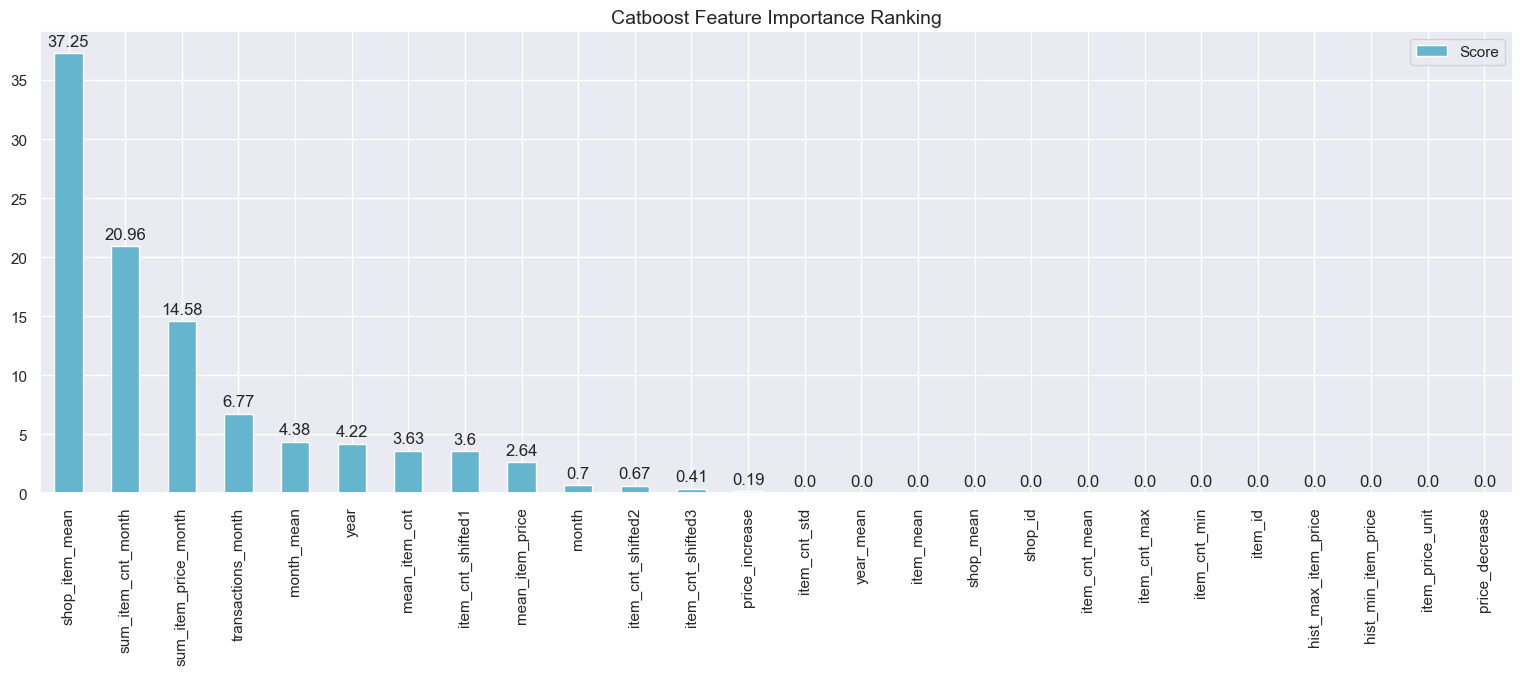

In [53]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [55]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)


In [56]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

Train rmse: 0.6097249762307249
Validation rmse: 0.600855016468833


In [57]:
catboost_test_pred

array([0.31797275, 0.02641992, 0.35227381, ..., 0.14572462, 0.02641992,
       0.05946536])